In [7]:
import pandas as pd
import os
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import random
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold

In [8]:
birds_df = pd.read_csv('birds.csv')
birds_df.head()

,class id,filepaths,labels,data set,scientific name
0,0.0,train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
1,0.0,train/ABBOTTS BABBLER/007.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
2,0.0,train/ABBOTTS BABBLER/008.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
3,0.0,train/ABBOTTS BABBLER/009.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
4,0.0,train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI


In [9]:
unique_species_count = birds_df['labels'].nunique()
samples_per_species = birds_df['labels'].value_counts()
images_per_dataset = birds_df['data set'].value_counts()
scientific_name_consistency = birds_df.groupby('labels')['scientific name'].nunique()


summary_report = {
    "Unique Species Count": unique_species_count,
    "Samples Per Species": samples_per_species.describe(), # Statistical summary
    "Images Per Dataset": images_per_dataset,
    "Label-Scientific Name Consistency": scientific_name_consistency[scientific_name_consistency > 1] # Inconsistencies
}

summary_report


{'Unique Species Count': 525,
 'Samples Per Species': count    525.000000
 mean     171.209524
 std       20.621588
 min      140.000000
 25%      160.000000
 50%      168.000000
 75%      180.000000
 max      273.000000
 Name: labels, dtype: float64,
 'Images Per Dataset': train    84635
 test      2625
 valid     2625
 Name: data set, dtype: int64,
 'Label-Scientific Name Consistency': Series([], Name: scientific name, dtype: int64)}

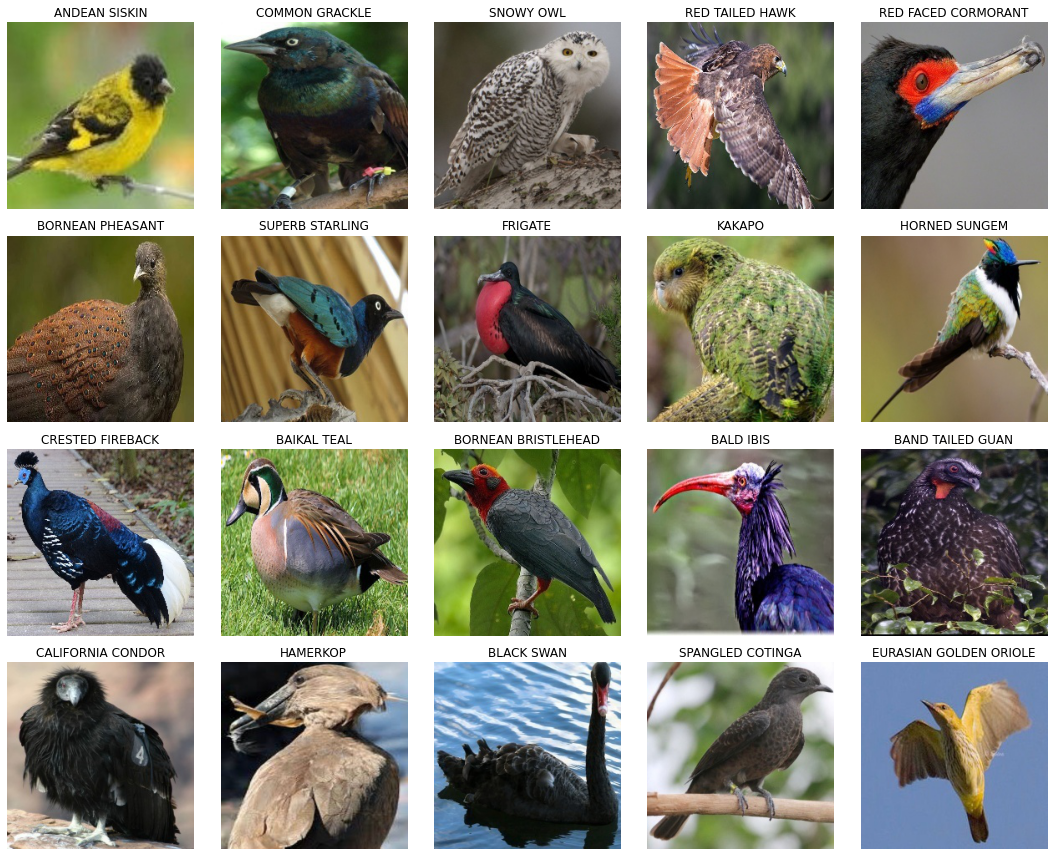

In [10]:
base_dir = 'train'

species_train_dirs = os.listdir(base_dir)


selected_species = random.sample(species_train_dirs, 20)


selected_images = []
for species in selected_species:
    species_dir = os.path.join(base_dir, species)
    chosen_image = random.choice(os.listdir(species_dir))
    selected_images.append((chosen_image, species))


def load_and_display_images(image_info_list, images_per_row=5):
    num_images = len(image_info_list)
    num_rows = num_images // images_per_row + (num_images % images_per_row > 0)
    
    plt.figure(figsize=(images_per_row * 3, num_rows * 3))
    for i, (image_name, species) in enumerate(image_info_list, 1):
        img_path = os.path.join(base_dir, species, image_name)
        img = image.load_img(img_path, target_size=(224, 224))
        plt.subplot(num_rows, images_per_row, i)
        plt.imshow(img)
        plt.title(species)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


load_and_display_images(selected_images)



In [11]:
image_dir = Path(base_dir)
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')


image_df = pd.concat([filepaths, labels], axis=1)

image_dir = Path('test')
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')


test_df = pd.concat([filepaths, labels], axis=1)

image_dir = Path('valid')
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')


valid_df = pd.concat([filepaths, labels], axis=1)

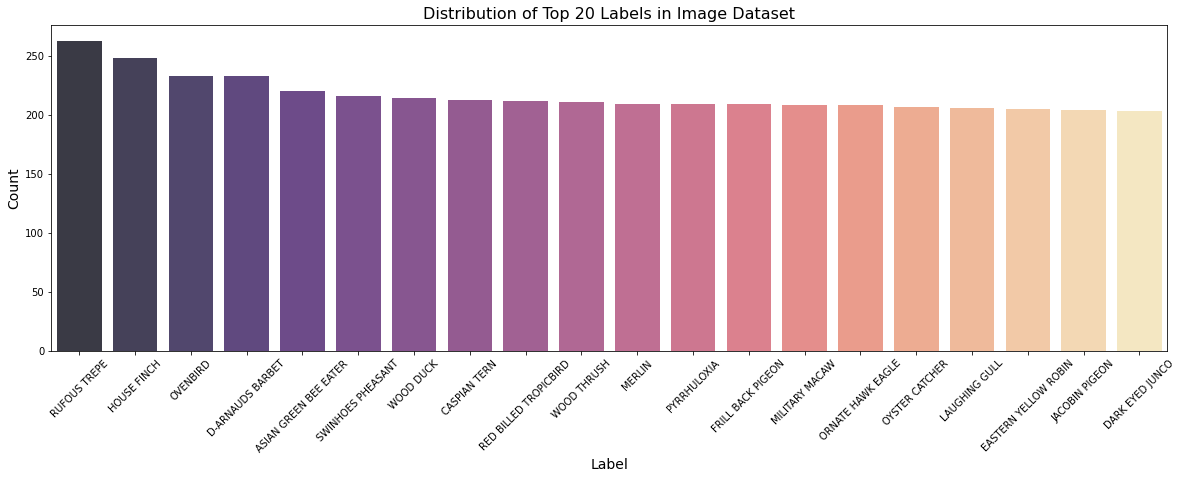

In [12]:
import seaborn as sns


top_20_label_counts =  image_df['Label'].value_counts()[:20]

plt.figure(figsize=(20, 6))


sns.barplot(x=top_20_label_counts.index, y=top_20_label_counts.values, alpha=0.8, palette='magma')


plt.title('Distribution of Top 20 Labels in Image Dataset', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)


plt.xticks(rotation=45)


plt.show()

In [13]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

In [22]:
batchsize = 32
targetsize = (224, 224)

train_images = train_generator.flow_from_dataframe(
    dataframe=image_df,
    x_col='Filepath',
    y_col='Label',
    target_size=targetsize,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batchsize,
    shuffle=True,
    seed=42
    
)

val_images = train_generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='Filepath',
    y_col='Label',
    target_size=targetsize,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batchsize,
    shuffle=True,
    seed=42
    
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=targetsize,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batchsize,
    shuffle=False
)


Found 84635 validated image filenames belonging to 525 classes.
Found 2625 validated image filenames belonging to 525 classes.
Found 2625 validated image filenames belonging to 525 classes.


In [15]:
from tensorflow.keras.layers import BatchNormalization

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5), 
    BatchNormalization(),
    Dense(525, activation='softmax') 
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Assuming `train_images`, `val_images`, and `test_images` are properly set up
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    epochs=10, 
    validation_data=val_images,
    validation_steps=len(val_images)
)

eval_result = model.evaluate(test_images)
print(f'Test Loss: {eval_result[0]}, Test Accuracy: {eval_result[1]}')

model.save('ver1_bird_species_cnn_model.h5')


2024-04-24 02:19:01.092783: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-24 02:19:03.207609: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78911 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2024-04-24 02:19:03.209375: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 78911 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:0f:00.0, compute capability: 8.0
2024-04-24 02:19:03.211004: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/rep

Epoch 1/10


2024-04-24 02:19:05.460424: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2024-04-24 02:19:07.319525: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2645/2645 [==============================] - 278s 104ms/step - loss: 4.8293 - accuracy: 0.1049 - val_loss: 2.9984 - val_accuracy: 0.3733
Epoch 2/10
2645/2645 [==============================] - 198s 75ms/step - loss: 3.0868 - accuracy: 0.3339 - val_loss: 1.7505 - val_accuracy: 0.5977
Epoch 3/10
2645/2645 [==============================] - 177s 67ms/step - loss: 2.2240 - accuracy: 0.4894 - val_loss: 1.4513 - val_accuracy: 0.6514
Epoch 4/10
2645/2645 [==============================] - 191s 72ms/step - loss: 1.6712 - accuracy: 0.5998 - val_loss: 1.1340 - val_accuracy: 0.7246
Epoch 5/10
2645/2645 [==============================] - 171s 65ms/step - loss: 1.2043 - accuracy: 0.6958 - val_loss: 1.1459 - val_accuracy: 0.7242
Epoch 6/10
2645/2645 [==============================] - 193s 73ms/step - loss: 0.8807 - accuracy: 0.7659 - val_loss: 1.1306 - val_accuracy: 0.7276
Epoch 7/10
2645/2645 [==============================] - 178s 67ms/step - loss: 0.7064 - accuracy: 0.8045 - val_loss: 1.2462 - va

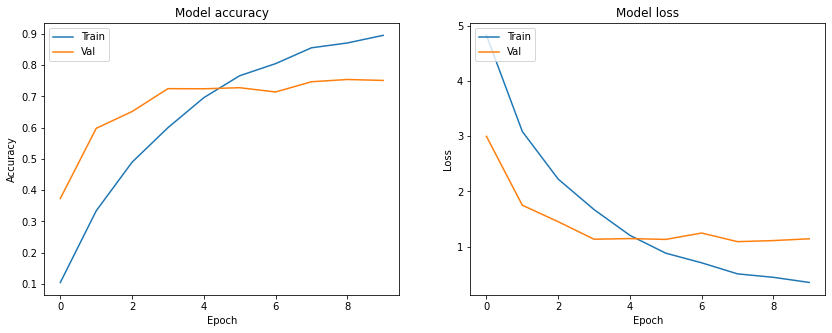

In [16]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()


In [17]:


predictions_proba = model.predict(test_images)
predictions = predictions_proba.argmax(axis=1)  
true_classes = test_images.classes 

In [18]:
f1_macro = f1_score(true_classes, predictions, average='macro')
print(f'F1 Score (Macro): {f1_macro}')


F1 Score (Macro): 0.770085394219848


In [19]:

n_classes = len(test_images.class_indices)
true_classes_binarized = label_binarize(true_classes, classes=[i for i in range(n_classes)])


roc_auc = roc_auc_score(true_classes_binarized, predictions_proba, multi_class='ovr')  # 'ovr' means One-vs-Rest
print(f'ROC AUC: {roc_auc}')


ROC AUC: 0.9979640857869864


In [27]:
batch_size = 32
target_size = (224, 224)

def create_generator(dataframe, batch_size, target_size, shuffle=True, seed=None):
    datagen = ImageDataGenerator(rescale=1./255)
    return datagen.flow_from_dataframe(
        dataframe=dataframe,
        x_col='Filepath',
        y_col='Label',
        target_size=target_size,
        color_mode='rgb',
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=shuffle,
        seed=seed
    )


def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5), 
        BatchNormalization(),
        Dense(525, activation='softmax') 
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = []

for train_index, val_index in kf.split(image_df):
    train_df = image_df.iloc[train_index]
    val_df = image_df.iloc[val_index]

    
    train_images = create_generator(train_df, batch_size, target_size)
    val_images = create_generator(val_df, batch_size, target_size)

    
    model = create_model()

    # Fit the model
    history = model.fit(
        train_images,
        steps_per_epoch=len(train_images),
        epochs=10, 
        validation_data=val_images,
        validation_steps=len(val_images)
    )
    
    
    test_images = create_generator(test_df, batch_size, target_size, shuffle=False) 
    eval_result = model.evaluate(test_images)
    results.append(eval_result[1]) 
    

average_accuracy = np.mean(results)
print("Average Accuracy:", average_accuracy)

Found 67708 validated image filenames belonging to 525 classes.
Found 16927 validated image filenames belonging to 525 classes.
Epoch 1/10
2116/2116 [==============================] - 161s 76ms/step - loss: 4.7114 - accuracy: 0.1172 - val_loss: 3.2790 - val_accuracy: 0.3159
Epoch 2/10
2116/2116 [==============================] - 158s 75ms/step - loss: 3.0502 - accuracy: 0.3398 - val_loss: 2.2629 - val_accuracy: 0.5032
Epoch 3/10
2116/2116 [==============================] - 160s 76ms/step - loss: 2.1760 - accuracy: 0.5011 - val_loss: 1.8147 - val_accuracy: 0.5889
Epoch 4/10
2116/2116 [==============================] - 161s 76ms/step - loss: 1.5122 - accuracy: 0.6325 - val_loss: 2.9287 - val_accuracy: 0.4065
Epoch 5/10
2116/2116 [==============================] - 163s 77ms/step - loss: 1.0676 - accuracy: 0.7245 - val_loss: 1.6519 - val_accuracy: 0.6309
Epoch 6/10
2116/2116 [==============================] - 161s 76ms/step - loss: 0.7278 - accuracy: 0.8006 - val_loss: 1.5573 - val_accurac

Transfer Learning

In [28]:
from tensorflow.keras.optimizers import Adam
batch_size = 32
target_size = (224, 224)

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(*target_size, 3))


base_model.trainable = True

for layer in base_model.layers[:-20]:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(2048, activation='relu'),  
    Dropout(0.5),
    Dense(525, activation='softmax')
])


optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_bird_species_cnn_model.h5', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001, verbose=1)


history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    epochs=10, 
    validation_data=val_images,
    validation_steps=len(val_images),
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)




Epoch 1/10
2645/2645 [==============================] - ETA: 0s - loss: 1.8179 - accuracy: 0.6212
Epoch 00001: val_loss improved from inf to 0.31133, saving model to best_bird_species_cnn_model.h5


/apps/tensorflow/2.7.0/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


2645/2645 [==============================] - 227s 85ms/step - loss: 1.8179 - accuracy: 0.6212 - val_loss: 0.3113 - val_accuracy: 0.9250 - lr: 1.0000e-04
Epoch 2/10
2645/2645 [==============================] - ETA: 0s - loss: 0.5550 - accuracy: 0.8568
Epoch 00002: val_loss improved from 0.31133 to 0.21010, saving model to best_bird_species_cnn_model.h5
2645/2645 [==============================] - 196s 74ms/step - loss: 0.5550 - accuracy: 0.8568 - val_loss: 0.2101 - val_accuracy: 0.9455 - lr: 1.0000e-04
Epoch 3/10
2645/2645 [==============================] - ETA: 0s - loss: 0.3743 - accuracy: 0.9006
Epoch 00003: val_loss improved from 0.21010 to 0.15772, saving model to best_bird_species_cnn_model.h5
2645/2645 [==============================] - 201s 76ms/step - loss: 0.3743 - accuracy: 0.9006 - val_loss: 0.1577 - val_accuracy: 0.9543 - lr: 1.0000e-04
Epoch 4/10
2645/2645 [==============================] - ETA: 0s - loss: 0.2762 - accuracy: 0.9247
Epoch 00004: val_loss improved from 0.157

In [29]:
best_model = load_model('best_bird_species_cnn_model.h5')  
eval_result = best_model.evaluate(test_images)  
print(f'Test Loss: {eval_result[0]}, Test Accuracy: {eval_result[1]}')

83/83 [==============================] - 8s 83ms/step - loss: 0.2263 - accuracy: 0.9288
Test Loss: 0.2262885570526123, Test Accuracy: 0.928761899471283


In [30]:
test_predictions_proba = best_model.predict(test_images)
test_predictions = np.argmax(test_predictions_proba, axis=1)
true_classes = test_images.classes

f1_macro = f1_score(true_classes, test_predictions, average='macro')
print(f'F1 Score (Macro): {f1_macro}')

true_classes_binarized = to_categorical(true_classes, num_classes=n_classes)
roc_auc = roc_auc_score(true_classes_binarized, test_predictions_proba, multi_class='ovr')
print(f'AUROC: {roc_auc}')


F1 Score (Macro): 0.9274460062191154
AUROC: 0.999941548527808


K-fold validation